Steps:

1. Load the dataset.
2. Load the autoencoder.
3. Load the trained GAN.
4. Apply the trained GAN to the latent code.

In [1]:
import torch
from torch import nn

import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from matplotlib import pyplot as plt


from torchvision.datasets import MNIST
from torchvision import transforms as T
from torchvision import models

/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Load data files
train_dataset = MNIST(root = ".", download = True, train = True)
test_dataset = MNIST(root = ".", download = True, train = False)

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, dataset, return_tensor = False):
        super().__init__()

        self.return_tensor = return_tensor

        self.base_rotator = T.Compose(
            [
                T.ToTensor(),
                T.Normalize([0.5,], [0.5,])
            ]
        )

        self.rotators = [
            T.Compose(
                [
                    T.ToTensor(),
                    T.Normalize([0.5,], [0.5,]),
                    T.RandomRotation((30 * factor, 30 * factor)),
                ]
            )

            for factor in range(1, 12)
        ]

        self.dataset = dataset
        
    def __getitem__(self, index):
        mapped_index = int(index / 12) # Index to base image to be rotated
        rotation_index = index % 12    # Index for angular rotation to be applied
        
        image, label = self.dataset.__getitem__(mapped_index)
        image = self.rotators[rotation_index - 1](image) if rotation_index > 0 else self.base_rotator(image)
        
        return (image, label) if self.return_tensor else (T.ToPILImage()(image), label)
        

    def __len__(self):
        return self.dataset.__len__() * 12

In [4]:
train_dataset = MNISTDataset(dataset = train_dataset, return_tensor = True)
test_dataset = MNISTDataset(dataset = test_dataset, return_tensor = True)

In [5]:
BATCH_SIZE = 128

train_dl = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, pin_memory = True)

In [6]:
class ParticleEncoder(nn.Module):
    def __init__(self, latent_dim, p = .4):
        super(ParticleEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        self.p = p
        
        self.l1 = nn.Conv2d(in_channels = 1, out_channels = 8, stride = 1, padding = 1, kernel_size = 3)
        self.b1 = nn.BatchNorm2d(8)
        self.d1 = nn.Dropout(self.p)
        
        self.l2 = nn.Conv2d(in_channels = 8, out_channels = 16, stride = 1, padding = 1, kernel_size = 3)
        self.b2 = nn.BatchNorm2d(16)
        self.d2 = nn.Dropout(self.p)
        
        self.l3 = nn.Conv2d(in_channels = 16, out_channels = 32, stride = 3, padding = 1, kernel_size = 3)
        self.b3 = nn.BatchNorm2d(32)
        self.d3 = nn.Dropout(self.p)
        
        self.l4 = nn.Conv2d(in_channels = 32, out_channels = 64, stride = 2, padding = 1, kernel_size = 2)
        self.b4 = nn.BatchNorm2d(64)
        
        self.linear = nn.Linear(64*6*6, self.latent_dim)
        
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        y = self.d1(F.relu(self.b1(self.l1(x))))
        y = self.d2(F.relu(self.b2(self.l2(y))))
        y = self.d3(F.relu(self.b3(self.l3(y))))
        
        y = F.relu(self.b4(self.l4(y)))
        
        y = self.flatten(y)
        y = self.linear(y)
        
        return y

In [7]:
class ParticleDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ParticleDecoder, self).__init__()
        
        self.latent_dim = latent_dim

        self.linear = nn.Linear(self.latent_dim, 64*6*6)
        
        self.l1 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 3)
        self.b1 = nn.BatchNorm2d(32)
        
        self.l2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 2, padding = 2, stride = 2)
        self.b2 = nn.BatchNorm2d(16)
        
        self.l3 = nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 2, padding = 2, stride = 2)
        self.b3 = nn.BatchNorm2d(8)
        
        self.l4 = nn.Conv2d(in_channels = 8, out_channels = 1, kernel_size = 2, padding = 2, stride = 2)
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        y = F.relu(self.b1(self.l1(x.view(-1, 64, 6, 6))))
        y = F.relu(self.b2(self.l2(y)))
        y = F.relu(self.b3(self.l3(y)))
        
        y = torch.tanh(self.l4(y).view(-1, 1, 28, 28))
        
        return y
        

In [8]:
class ParticleAutoEncoder(nn.Module):
    def __init__(self, in_dim = 128, out_dim = 128, encoder = None, decoder = None):
        super(ParticleAutoEncoder, self).__init__()

        self.in_dim, self.out_dim = in_dim, out_dim
        
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x_encoded = self.encoder(x)
        return self.decoder(x_encoded)

    @torch.no_grad()
    def generate_images(self, x_, code_type = 'code'):
        self.eval()
        if code_type == 'code':
            img = self.decoder(x_)
        elif code_type == 'image':
            img = self(x_)
        else:
            raise Exception('Provide a random code [-1, 1] or an image [-1, 1, 28, 28].')
        
        return img

    @torch.no_grad()
    def generate_code(self, image):
        self.eval()
        code = self.encoder(image)
        return code

In [9]:
class LieGenerator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim

        self.layer_norm = nn.LayerNorm(self.latent_dim)

        self.linear1 = nn.Linear(in_features = self.latent_dim, out_features = self.latent_dim * 2)
        self.bn1 = nn.BatchNorm1d(self.latent_dim * 2)

        self.linear2 = nn.Linear(in_features = self.latent_dim * 2, out_features = self.latent_dim * 2)
        self.bn2 = nn.BatchNorm1d(self.latent_dim * 2)

        self.linear3 = nn.Linear(in_features = self.latent_dim * 2, out_features = self.latent_dim)
        
    def forward(self, x):
        x = self.layer_norm(x)
        
        x = self.bn1(self.linear1(x))
        x = F.relu(x)

        x = self.bn2(self.linear2(x))
        x = F.relu(x)

        x = self.linear3(x)
        
        return F.tanh(x)

In [10]:
class LieDiscriminator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim

        self.layer_norm = nn.LayerNorm(self.latent_dim)

        self.linear1 = nn.Linear(in_features = self.latent_dim, out_features = self.latent_dim * 2)
        self.bn1 = nn.BatchNorm1d(self.latent_dim * 2)

        self.linear2 = nn.Linear(in_features = self.latent_dim * 2, out_features = self.latent_dim * 2)
        self.bn2 = nn.BatchNorm1d(self.latent_dim * 2)

        self.linear3 = nn.Linear(in_features = self.latent_dim * 2, out_features = 2)
        
    def forward(self, x):
        x = self.layer_norm(x)
        
        x = self.bn1(self.linear1(x))
        x = F.relu(x)

        x = self.bn2(self.linear2(x))
        x = F.relu(x)

        x = self.linear3(x)
        
        return F.softmax(x, dim = -1)

In [11]:
class LieGAN(nn.Module):
    def __init__(self, generator = None, discriminator = None):
        super().__init__()

        self.discriminator = discriminator
        self.generator = generator

    def forward(self, x, noise):
        lie_group_element = self.generator(noise)
        transformed_x = x * lie_group_element

        return self.discriminator(transformed_x)

In [12]:
latent_dim = 32
DEVICE = "cuda"

In [13]:
encoder = ParticleEncoder(latent_dim = latent_dim)
decoder = ParticleDecoder(latent_dim = latent_dim)

In [14]:
auto_encoder = ParticleAutoEncoder(
    encoder = encoder,
    decoder = decoder
).to(DEVICE)

In [15]:
auto_encoder.load_state_dict(torch.load("new_autoencoder.pt"))

<All keys matched successfully>

In [16]:
generator = LieGenerator(latent_dim = latent_dim)
discriminator = LieDiscriminator(latent_dim = latent_dim)

In [17]:
# Instantiate GAN model
gan_model = LieGAN(generator = generator, discriminator = discriminator).to(DEVICE)

In [18]:
gan_model.load_state_dict(torch.load("latent_gan.pt"))

<All keys matched successfully>

In [19]:
for p in auto_encoder.parameters():
    p.requires_grad_(False)

for p in gan_model.parameters():
    p.requires_grad_(False)

auto_encoder.eval()
gan_model.eval()

LieGAN(
  (discriminator): LieDiscriminator(
    (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (linear1): Linear(in_features=32, out_features=64, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear2): Linear(in_features=64, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear3): Linear(in_features=64, out_features=2, bias=True)
  )
  (generator): LieGenerator(
    (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (linear1): Linear(in_features=32, out_features=64, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear2): Linear(in_features=64, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear3): Linear(in_features=64, out_features=32, bias=True)
  )
)

In [20]:
sample_images, sample_labels = next(iter(train_dl))

In [21]:
sample_images.shape

torch.Size([128, 1, 28, 28])

In [22]:
sample_labels

tensor([0, 3, 6, 9, 0, 5, 5, 1, 8, 2, 7, 4, 0, 1, 9, 3, 1, 8, 5, 9, 6, 4, 8, 5,
        6, 8, 9, 9, 0, 0, 5, 4, 2, 9, 9, 1, 4, 6, 6, 8, 0, 9, 5, 0, 4, 1, 0, 7,
        8, 0, 0, 7, 6, 0, 4, 2, 6, 8, 2, 0, 9, 2, 7, 6, 0, 4, 2, 8, 6, 8, 0, 7,
        5, 4, 1, 0, 2, 7, 4, 4, 9, 9, 6, 0, 8, 3, 2, 2, 3, 6, 9, 2, 1, 5, 2, 8,
        0, 6, 2, 1, 3, 0, 3, 9, 3, 9, 4, 7, 9, 9, 9, 1, 6, 2, 7, 7, 2, 1, 7, 1,
        4, 2, 5, 1, 7, 1, 5, 6])

In [23]:
# Generate code for image batch
sample_code = auto_encoder.encoder(sample_images.to(DEVICE))

In [24]:
sample_code.shape

torch.Size([128, 32])

In [25]:
### Code mean (determined via pretraining)
MEAN = .02
STD = .233

In [26]:
noise = torch.distributions.Normal(loc = MEAN, scale = STD).sample(sample_code.shape).to(DEVICE)

In [27]:
noise.shape

torch.Size([128, 32])

In [28]:
generated_symmetries = gan_model.generator(noise)

In [29]:
generated_symmetries.shape

torch.Size([128, 32])

In [30]:
sample_code_orbit = generated_symmetries * sample_code.to(DEVICE)

In [31]:
decoded_sample_orbit = auto_encoder.decoder(sample_code_orbit)
decoded_sample_code = auto_encoder.decoder(sample_code)

In [32]:
decoded_sample_orbit.shape

torch.Size([128, 1, 28, 28])

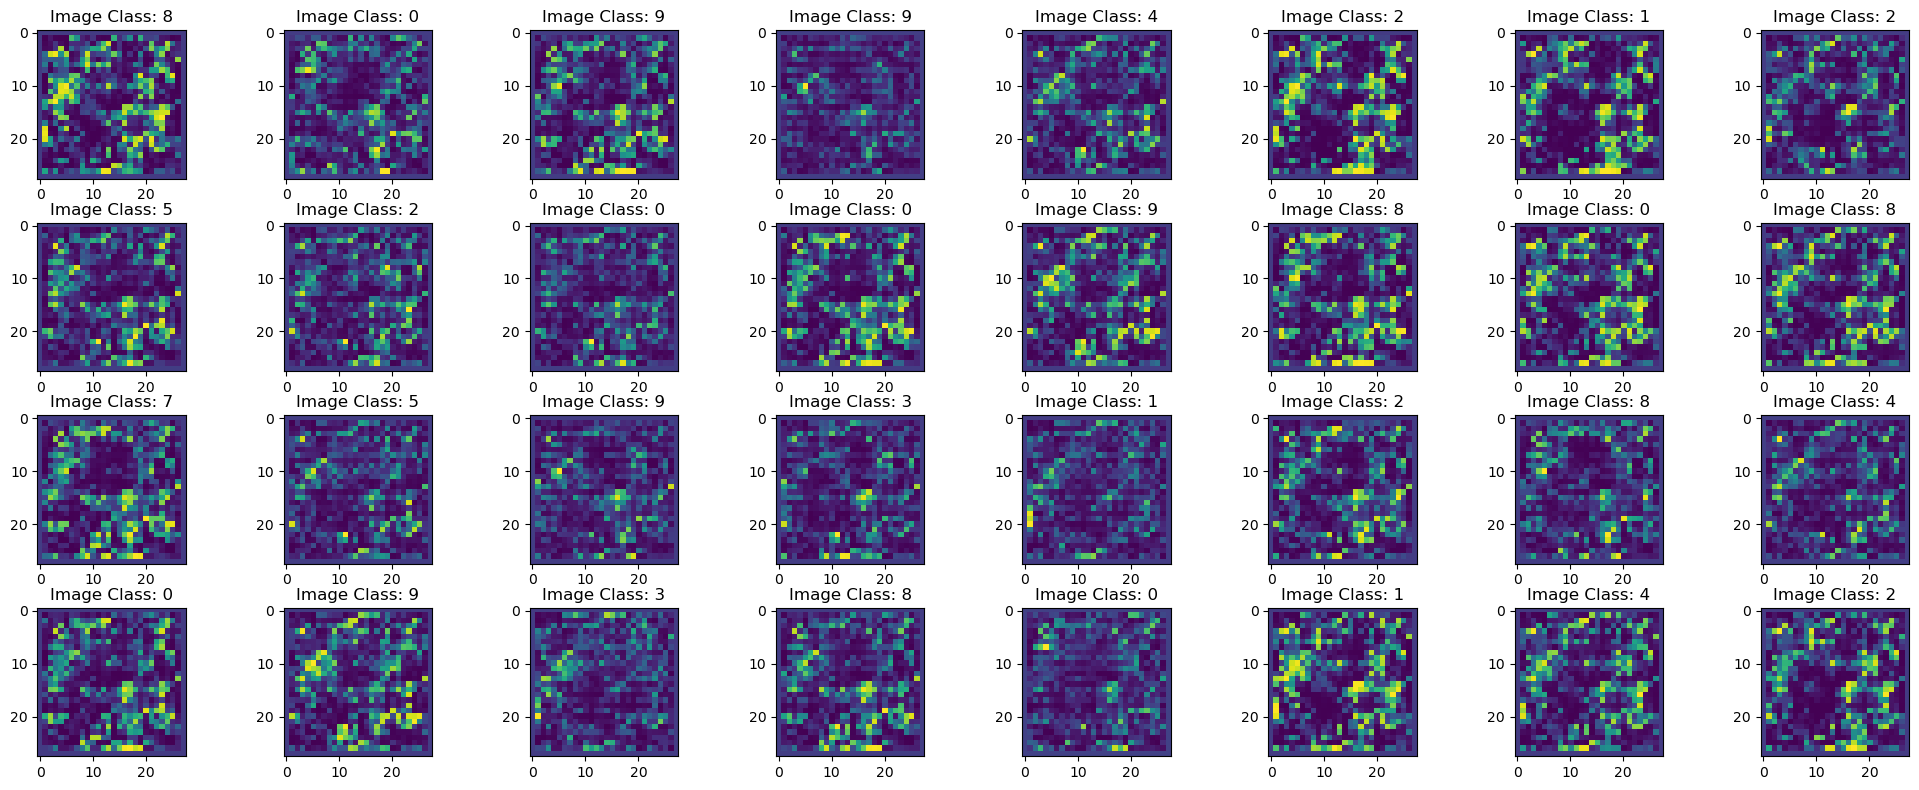

In [33]:
# Visualization of generated images (symmetries + code)
fig, ax = plt.subplots(nrows = 4, ncols = 8, figsize = (20, 8))

ix = 0
ixs = np.random.randint(low = 0, high = len(decoded_sample_orbit), size = (32,))
for i in range(4):
    for j in range(8):
        index = ixs[ix]
        ax[i, j].imshow(decoded_sample_orbit[index].detach().cpu().squeeze(),)
        ax[i, j].set_title(f"Image Class: {sample_labels[index].item()}")
        ix += 1

plt.tight_layout(h_pad = 0.01)
plt.show(); plt.close('all')

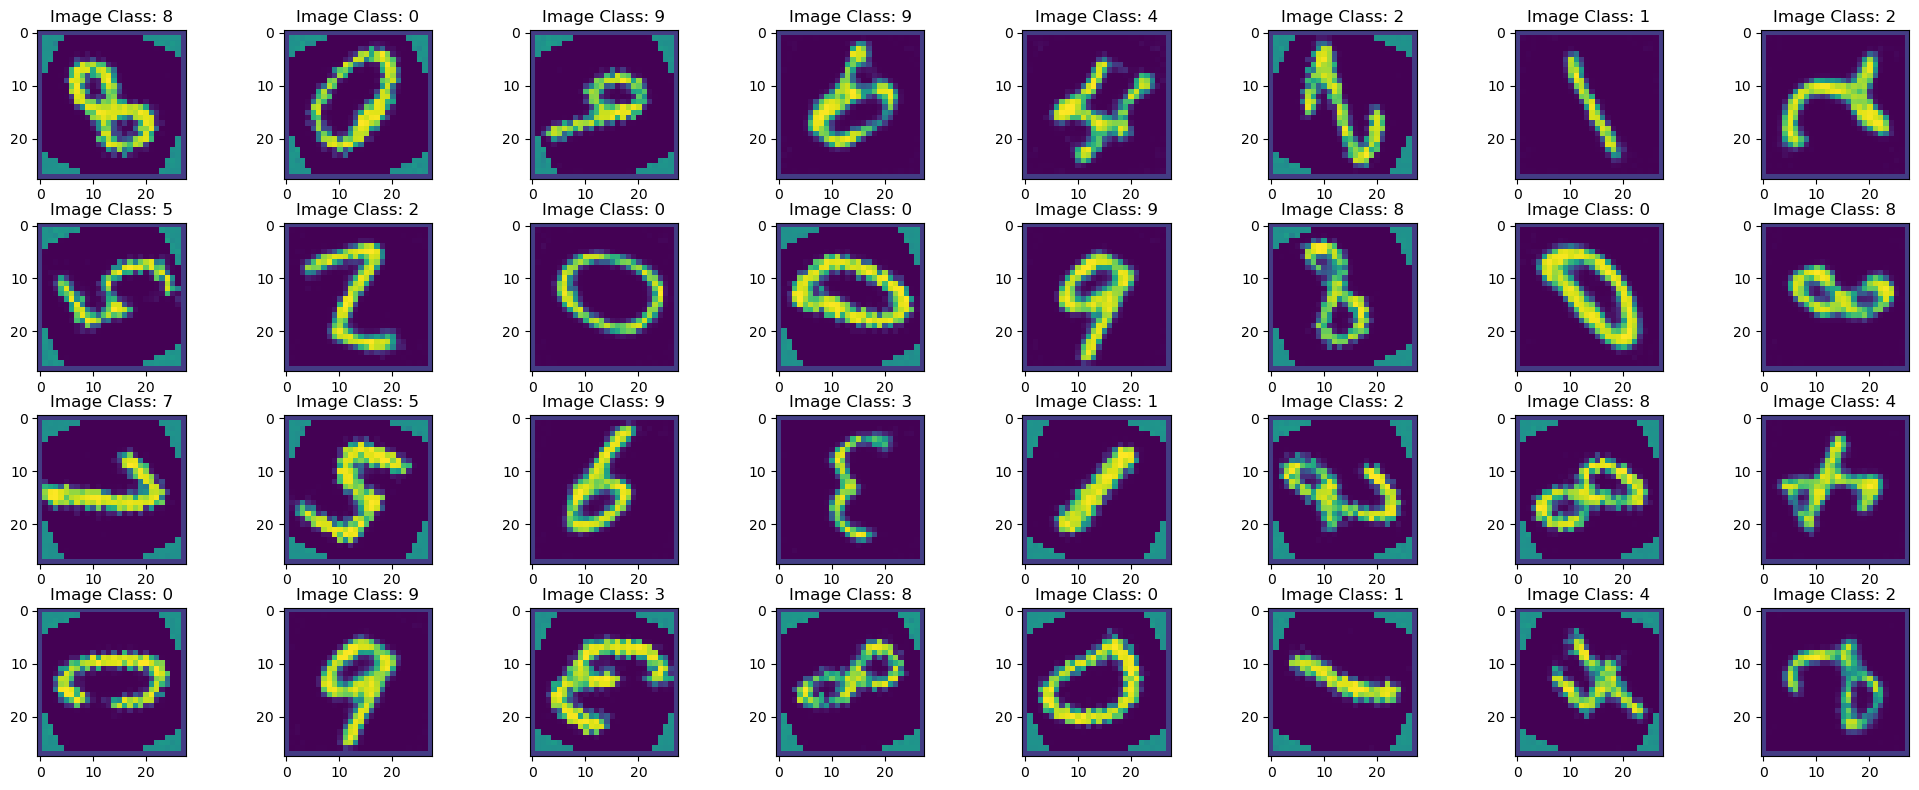

In [34]:
# Visualization of generated images (code)
fig, ax = plt.subplots(nrows = 4, ncols = 8, figsize = (20, 8))

ix = 0
for i in range(4):
    for j in range(8):
        index = ixs[ix]
        ax[i, j].imshow(decoded_sample_code[index].cpu().squeeze(),)
        ax[i, j].set_title(f"Image Class: {sample_labels[index].item()}")
        ix += 1

plt.tight_layout(h_pad = 0.01)
plt.show(); plt.close('all')

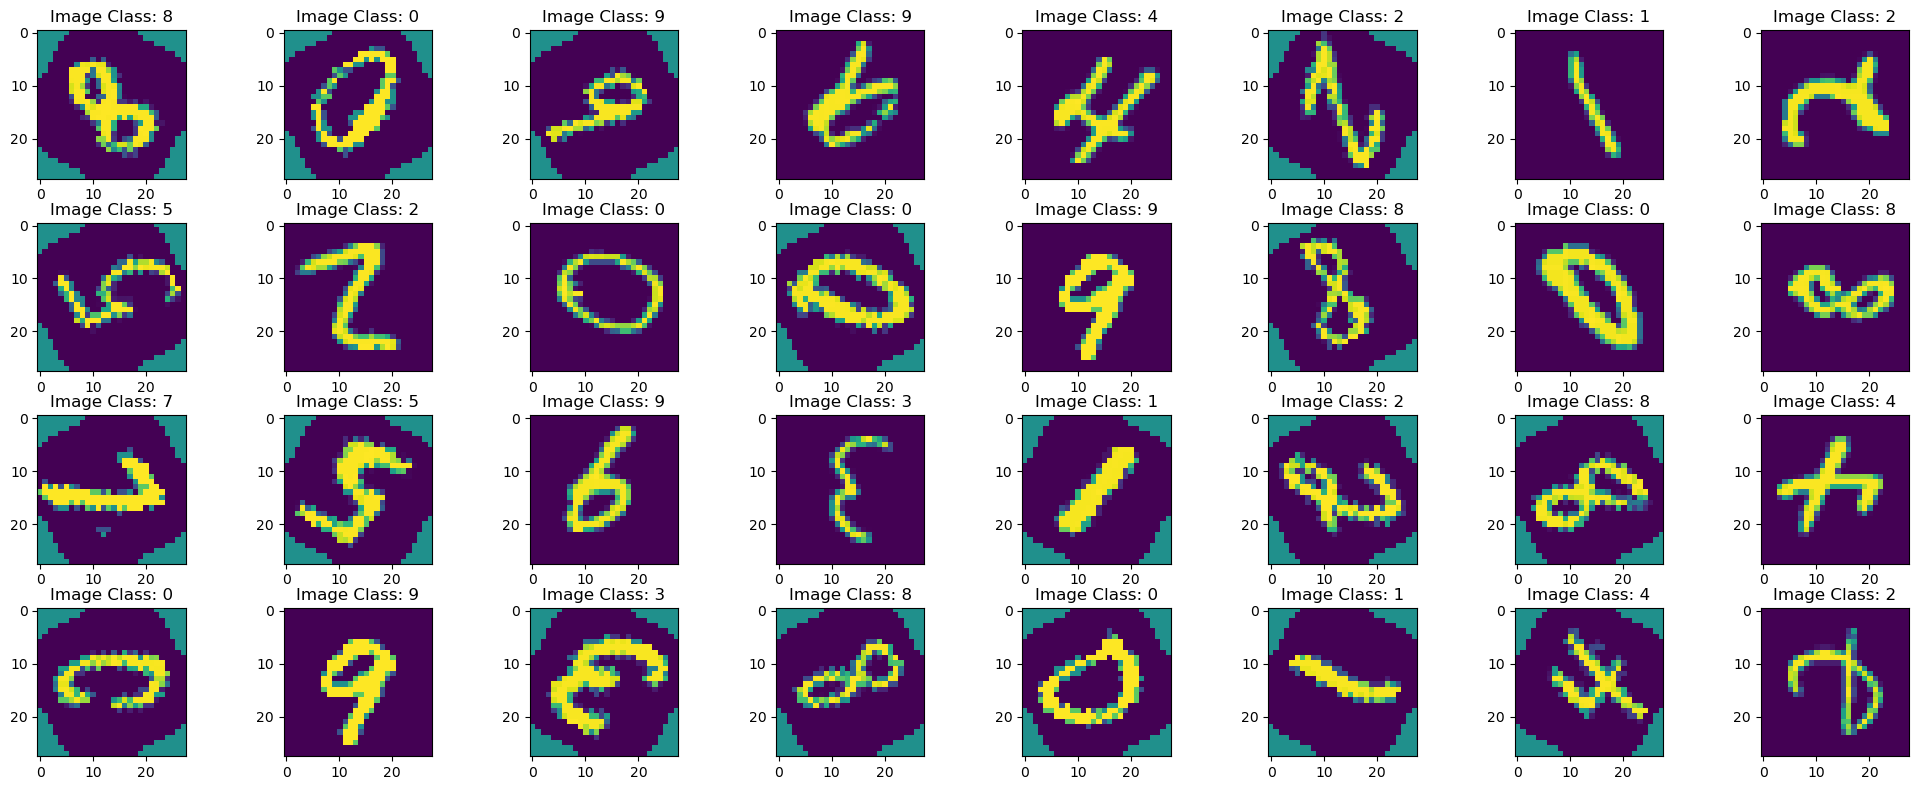

In [35]:
# Visualization of original images
fig, ax = plt.subplots(nrows = 4, ncols = 8, figsize = (20, 8))

ix = 0
for i in range(4):
    for j in range(8):
        index = ixs[ix]
        ax[i, j].imshow(sample_images[index].cpu().squeeze(),)
        ax[i, j].set_title(f"Image Class: {sample_labels[index].item()}")
        ix += 1

plt.tight_layout(h_pad = 0.01)
plt.show(); plt.close('all')

### Observation

As can be observed from the images visualized above, although the autoencoder does it job almost perfectly, the symmetry generator is strongly lacking. Rather than generate actual meaningful symmetries, it only generates noise. Possible reasons for this may include:

1. __GAN Issues__: GANs are notoriously difficult to train.
 
2. __Symmetry-Code Combination__: The image code and the generated symmetry were combined via element-wise multiplication. This is not necessarily the best way to go, seeing as we are dealing with a latent space. More seasoned combination may be required.

3. __Training Time__: The GAN was only trained for 20 epochs. More time might be needed for the GAN to learn any meaningful symmetries.

4. __Data Distilation Techniques__: In this task, I was supposed to implement a data distillation technique to eliminate outliers from the data orbit. I thought on the problem quite a lot, but I was unable to come up with a meaningful approach due to time constraints. If I had more time, I'd look into this.